This other notebook use Octave, a free clone of MATLAB.

In [1]:
version

ans = 4.2.2


# Iterative computation example (signal filtering)

This short Octave example is meant to show how Julia can be very fast with iterative computations (e.g. `for` loops), thanks to JIT compilation.

Outline:

1. An example of iterative computation: exponential smoothing
2. How to measure the performance of a program using `tic`, `tac` macro

## A simple iterative computation: Exponential smoothing

[Exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing) (also known as "exponentially weighted moving average", "1st order Autoregressive filter", "1st order IIR filter" in signal processing) is a simple recursive filter which can smooth a times series $\{u_k\}_{k\in\mathbb{N}}$:

$$ y_k = ay_{k-1} + (1-a) u_k, \;\;\;\; k\in\mathbb{N}^+, a\in[0,1[$$

Parameter $a$ tunes the smoothing, between none ($a=0$) and strong smoothing ($a\to1^-$).

This is a simple example of a computation that **cannot be vectorized**. Therefore, iteration in a `for` loop cannot be avoided.

### Example data

a kind of random walk, 1000 pts

In [1]:
randn("seed", 0)

In [2]:
u = cumsum(randn(1000,1))

u =

  -2.1539e+00
  -3.8406e+00
  -4.1771e+00
  -3.2734e+00
  -3.2200e+00
  -2.8456e+00
  -3.2280e+00
  -3.0542e+00
  -2.5635e+00
  -2.1738e+00
  -2.5304e+00
  -2.2431e+00
  -3.4862e+00
  -3.2433e+00
  -2.4615e+00
  -1.7876e+00
  -2.2670e+00
  -3.7755e+00
  -3.5834e+00
  -4.7913e+00
  -6.3607e+00
  -7.6349e+00
  -6.2082e+00
  -6.0625e+00
  -7.3831e+00
  -7.2002e+00
  -8.4312e+00
  -7.4130e+00
  -7.0759e+00
  -8.1669e+00
  -5.7467e+00
  -5.1719e+00
  -5.2712e+00
  -4.5168e+00
  -4.0222e+00
  -4.1370e+00
  -4.8939e+00
  -4.2104e+00
  -3.3019e+00
  -2.5884e+00
  -3.3360e+00
  -3.7923e+00
  -4.3782e+00
  -3.7592e+00
  -2.2514e+00
  -1.2284e+00
  -1.7878e-01
  -2.6776e+00
  -3.7613e+00
  -2.1283e+00
  -2.9347e+00
  -2.8935e+00
  -1.6460e+00
  -3.4731e+00
  -3.9130e+00
  -2.4367e+00
  -1.5663e+00
  -3.4066e+00
  -3.9856e+00
  -4.0445e+00
  -3.6678e+00
  -4.3585e+00
  -3.2799e+00
  -4.8949e+00
  -4.6611e+00
  -3.8709e+00
  -4.4689e+00
  -3.5612e+00
  -3.4384e+00
  -3.4056e+00
  -1.2944e+00
 

   5.6505e+00
   6.6754e+00
   7.4402e+00
   8.4436e+00
   6.8781e+00
   5.8079e+00
   7.0243e+00
   6.9508e+00
   7.2440e+00
   6.6298e+00
   7.1480e+00
   9.5899e+00
   1.0583e+01
   1.1150e+01
   1.0714e+01
   1.1890e+01
   1.1406e+01
   1.0640e+01
   1.0706e+01
   1.1961e+01
   1.0515e+01
   1.0404e+01
   1.0802e+01
   1.0802e+01
   1.0982e+01
   1.1026e+01
   1.1768e+01
   1.1152e+01
   9.9468e+00
   1.1078e+01
   1.0835e+01
   1.1414e+01
   1.0240e+01
   8.3736e+00
   9.2208e+00
   7.3311e+00
   7.3904e+00
   6.9723e+00
   6.5184e+00
   4.3448e+00
   4.3892e+00
   3.5119e+00
   2.7647e+00
   4.7541e+00
   5.5466e+00
   6.0618e+00
   5.2675e+00
   4.7452e+00
   6.9796e+00
   4.0709e+00
   4.8950e+00
   6.0685e+00
   4.7100e+00
   4.5108e+00
   2.8735e+00
   3.1574e+00
   2.6597e+00
   4.0406e+00
   4.4934e+00
   4.5902e+00
   3.7077e+00
   4.1124e+00
   5.6967e+00
   3.9255e+00
   3.5674e+00
   3.2008e+00
   3.6568e+00
   3.0830e+00
   3.9384e+00
   4.0608e+00
   4.1578e+00
   4.3

In [3]:
length(u)

ans =  1000


### An Octave implemenation of the smoothing

In [4]:
function y = smooth(u, a)
    y = zeros(length(u),1);
    
    y(1) = (1-a)*u(1);
    for k=2:length(u)
        y(k) = a*y(k-1) + (1-a)*u(k);
    end
end

In [5]:
smooth(u, 0.9)

ans =

   -0.215386
   -0.577909
   -0.937831
   -1.171389
   -1.376249
   -1.523182
   -1.693666
   -1.829720
   -1.903099
   -1.930167
   -1.990193
   -2.015486
   -2.162555
   -2.270627
   -2.289718
   -2.239508
   -2.242255
   -2.395584
   -2.514367
   -2.742062
   -3.103930
   -3.557027
   -3.822140
   -4.046174
   -4.379867
   -4.661900
   -5.038827
   -5.276244
   -5.456208
   -5.727273
   -5.729219
   -5.673489
   -5.633260
   -5.521617
   -5.371678
   -5.248206
   -5.212778
   -5.112543
   -4.931481
   -4.697176
   -4.561060
   -4.484186
   -4.473591
   -4.402156
   -4.187076
   -3.891204
   -3.519962
   -3.435731
   -3.468292
   -3.334288
   -3.294327
   -3.254240
   -3.093419
   -3.131385
   -3.209549
   -3.132263
   -2.975670
   -3.018762
   -3.115450
   -3.208358
   -3.254305
   -3.364723
   -3.356238
   -3.510104
   -3.625200
   -3.649771
   -3.731688
   -3.714641
   -3.687021
   -3.658874
   -3.422427
   -3.223339
   -3.087380
   -2.847615
   -2.721474
   -2.593382
   -2

    6.752521
    6.604022
    6.418144
    6.474286
    6.233950
    6.100057
    6.096905
    5.958211
    5.813466
    5.519470
    5.283262
    5.020901
    4.922868
    4.879918
    4.850944
    4.736621
    4.674203
    4.776452
    4.691359
    4.578959
    4.441146
    4.362716
    4.234746
    4.205114
    4.190687
    4.187394
    4.203426
    4.260589
    4.199704
    4.187303
    4.238319
    4.304719
    4.332675
    4.339421
    4.406017
    4.522167
    4.522544
    4.519308
    4.608355
    4.692737
    4.629069
    4.533783
    4.384575
    4.311394
    4.191751
    4.086282
    4.132383
    4.178634
    4.310036
    4.577724
    4.778789
    4.956736
    5.022314
    5.162987
    5.198742
    5.222561
    5.466042
    5.661349
    6.077886
    6.431175
    6.796864
    7.314945
    7.834460
    8.199542
    8.393237
    8.539163
    8.638714
    8.737250
    8.712198
    8.607035
    8.522507
    8.286213
    7.991286
    7.668304
    7.389598
    7.288113
    7.175890

### Plot, to check that things work properly

a =  0.95000
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10


    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at li

    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at li

    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at line 62 column 9
    axes at line 66 column 10
    gca at line 58 column 9
    hold at lin

    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120

    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 c

    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
   

    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120

    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 c

    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
   

    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120

    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 c

    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
   

    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120

    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 c

    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
   

    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120

    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 c

    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
   

    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120

    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 c

    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
   

    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2vv__ at line 502 column 10
    __plt__>__plt2__ at line 248 column 14
    __plt__>__plt1__ at line 207 column 10
    __plt__ at line 119 column 17
    plot at line 223 column 10
    __line__ at line 120

    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot a

    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot a

    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot a

    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot a

    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot a

    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot at line 223 column 10
    __line__ at line 120 column 16
    line at line 56 column 8
    __plt__>__plt2ss__ at line 366 column 10
    __plt__>__plt2__ at line 238 column 14
    __plt__ at line 113 column 17
    plot a

    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 co

    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 co

    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 co

    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 co

    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    axes at line 66 column 10
    legend at line 545 column 19
    text at line 156 column 10
    legend at line 596 column 29
    text at line 156 column 10
    legend at line 596 column 29
    text at line 156 column 10
    legend at line 596 column 29
    text at line 156 column 10
    legend at line 596 column 29
    text at line 156 column 10
    legend at line 596 column 29
    text at line 156 column 10
    legend at line 596 column 29
    text at line 156 column 10
    legend at line 596 column 29
    text at line 156 column 10
    legend at line 596 column 29
    text at line 156 column 10
    legend at li

    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend

    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 608 column 13
    legend at line 613 column 13
    legend at line 613 column 13
    legend at line 613 column 13
    legend at line 613 column 13
    legend at line 613 column 13
    legend at line 613 column 13
    legend at line 613 column 13
    legend at line 613 column 13
    legend at line 613 column 13
    legend at line 613 column 13
    legend at line 613 column 13
    legend at line 613 column 13
    legend at line 613 column 13
    legend at line 613 column 13
    legend at line 613 column 13
    legend at line 613 column 13
    legend at line 613 column 13
    legend at line 613 column 13
    legend at line 613 column 13
    legend

    legend at line 788 column 11
    legend at line 788 column 11
    legend at line 788 column 11
    legend at line 788 column 11
    legend at line 788 column 11
    legend at line 788 column 11
    legend at line 788 column 11
    legend at line 788 column 11
    legend at line 788 column 11
    legend at line 788 column 11
    legend at line 788 column 11
    legend at line 788 column 11
    legend at line 788 column 11
    __line__ at line 120 column 16
    line at line 56 column 8
    legend at line 819 column 20
    __line__ at line 120 column 16
    line at line 56 column 8
    legend at line 819 column 20
    __line__ at line 120 column 16
    line at line 56 column 8
    legend at line 819 column 20
    __line__ at line 120 column 16
    line at line 56 column 8
    legend at line 819 column 20
    __line__ at line 120 column 16
    line at line 56 column 8
    legend at line 819 column 20
    __line__ at line 120 column 16
    line at line 56 column 8
    legend at line 819

    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    legend

    legend at line 904 column 11
    legend at line 904 column 11
    legend at line 904 column 11
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
  

    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    prin

    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    print at line 399 column 5
    prin

    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 213 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 c

    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 column 7
    print at line 518 column 14
    __gnuplot_print__>eps_drawnow at line 216 column 5
    __gnuplot_print__ at line 159 c

    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    prin

    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    print at line 529 column 11
    prin

    print at line 529 column 11


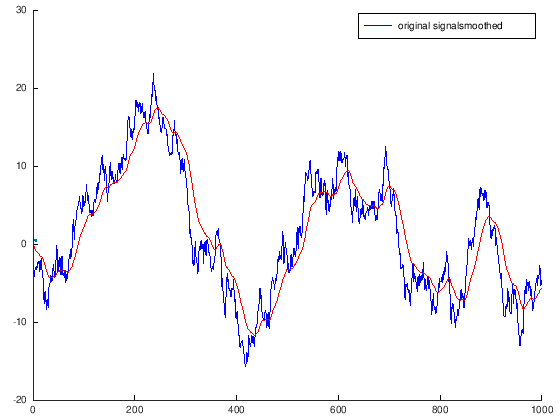

In [19]:
figure();
% Call function here

a = 0.95
hold on;
plot(u, 'b');
plot(smooth(u, a), 'r', lw=5, alpha=0.5);
legend(["original signal", "smoothed"]);
print -dpng signal_filtering_octave.png;

![](signal_filtering_octave.png)

## Performance analysis

With `tic()` and `toc()` like in Matlab.

In [21]:
tic();
smooth(u, 0.9);
toc();

Elapsed time is 0.0239961 seconds.


Since this time is too short to be meaningful, let's use more points (1M):

In [29]:
randn("seed", 0);
u = cumsum(randn(1e7, 1));

In [30]:
tic();
smooth(u, 0.9);
toc();

Elapsed time is 87.3255 seconds.


10 Mpts take **~70 ms** to compute, which means ~ 150 Mpts/s

In [40]:
1e7/70e-3/1e6

142.85714285714283